## Voter Turnout Analysis

C:\Users\finof\AppData\Local\Temp\ipykernel_15524\1558074444.py:11: DtypeWarning: Columns (14) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("D:\OSNA\Project\data.csv")


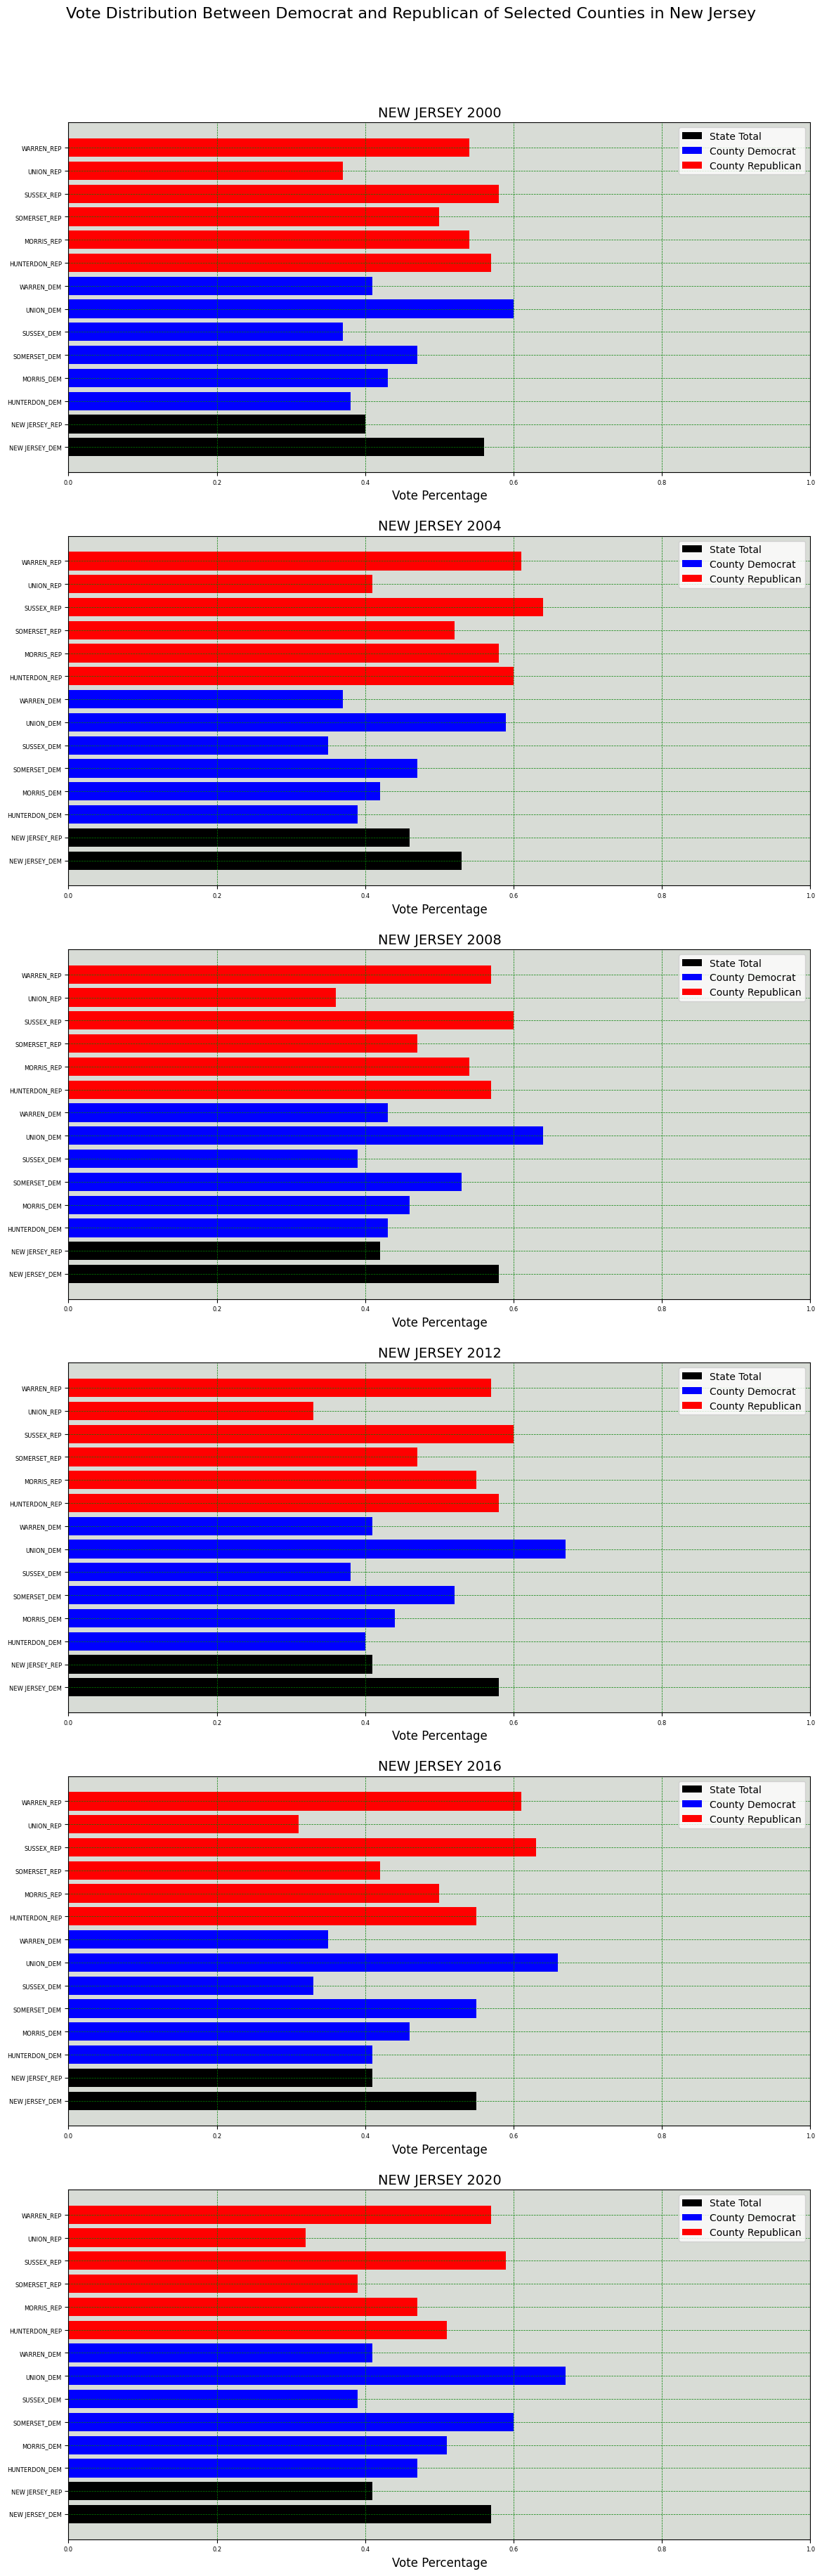

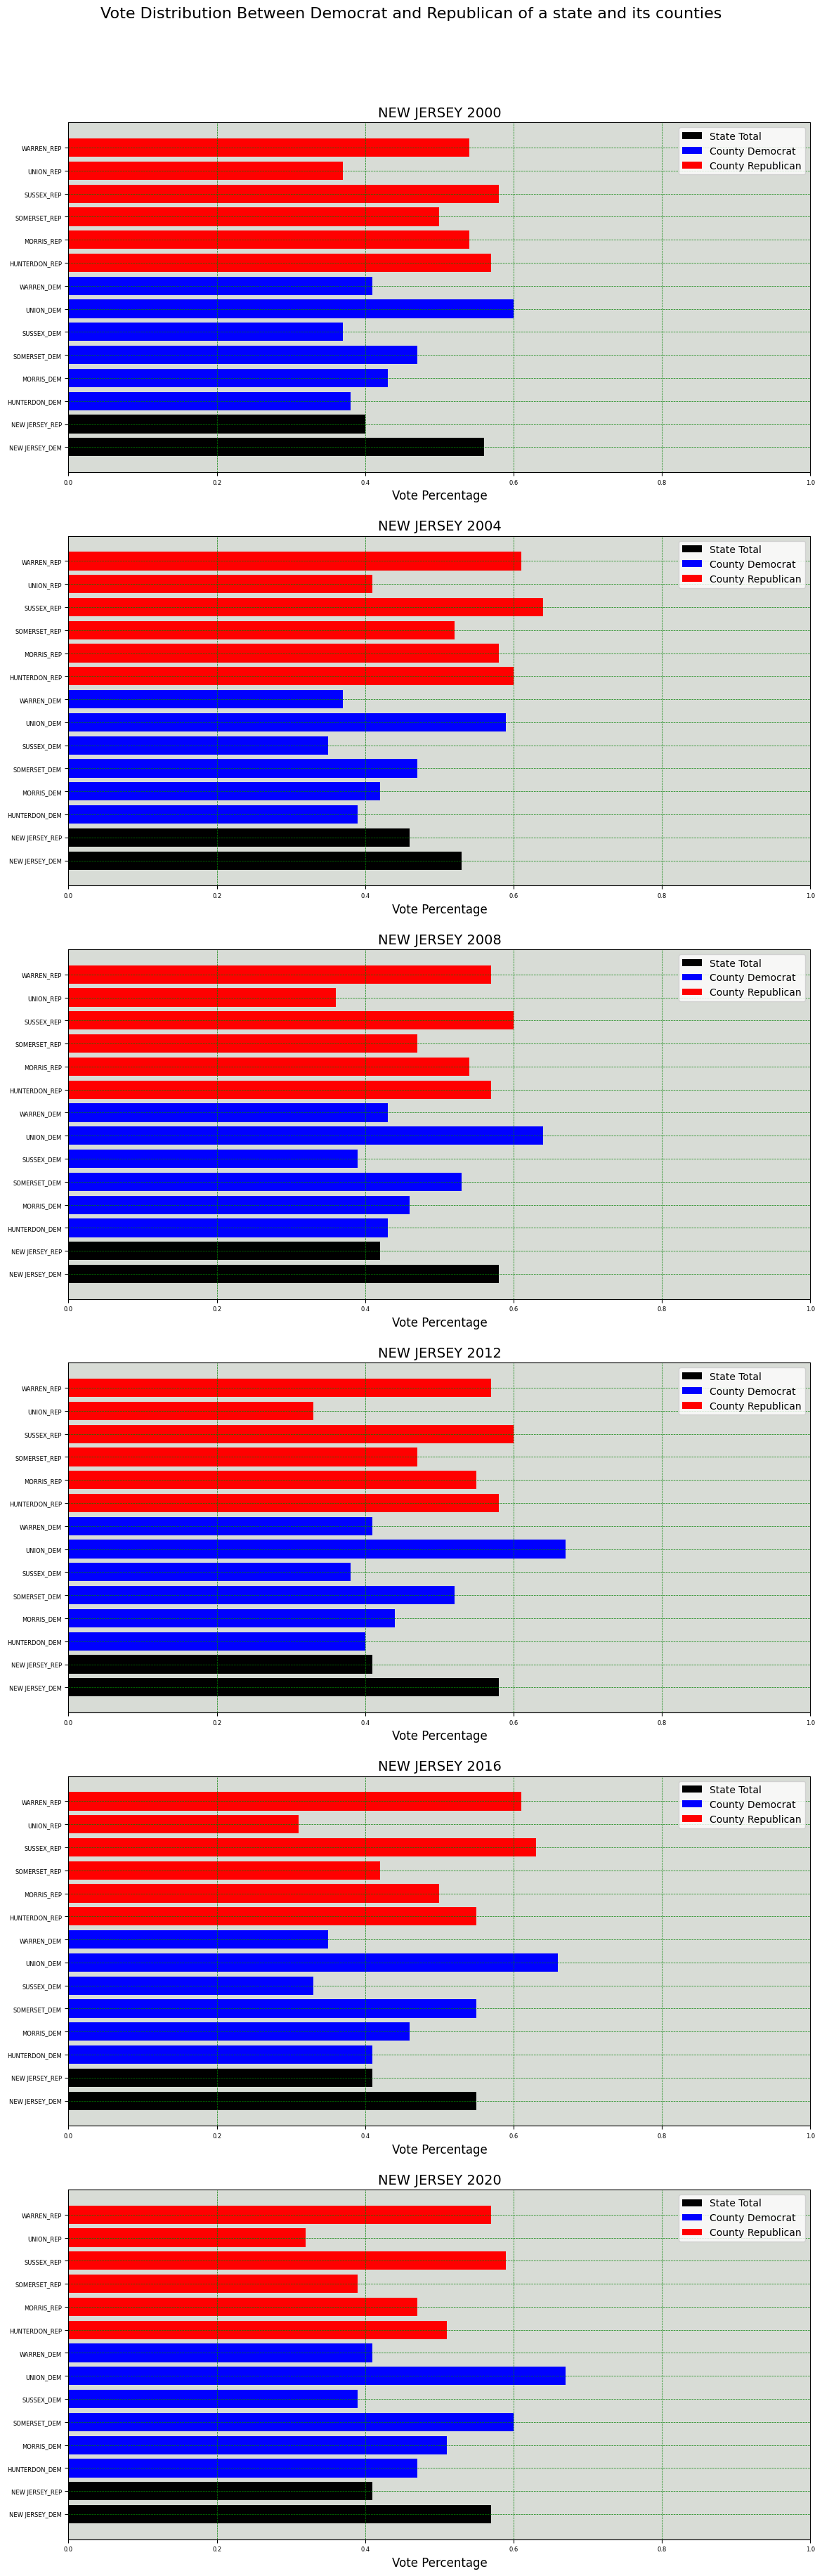

C:\Users\finof\AppData\Local\Temp\ipykernel_15524\1558074444.py:246: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'size': 6})


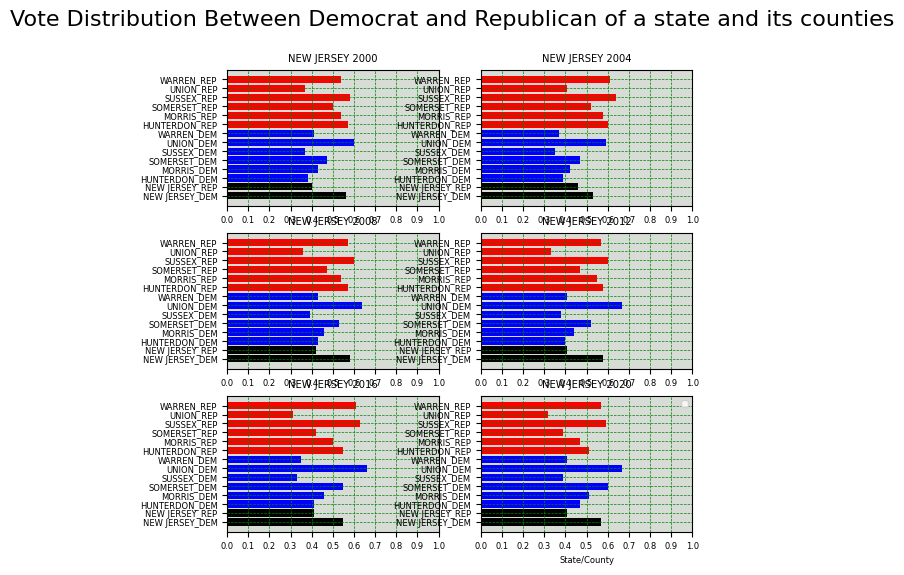

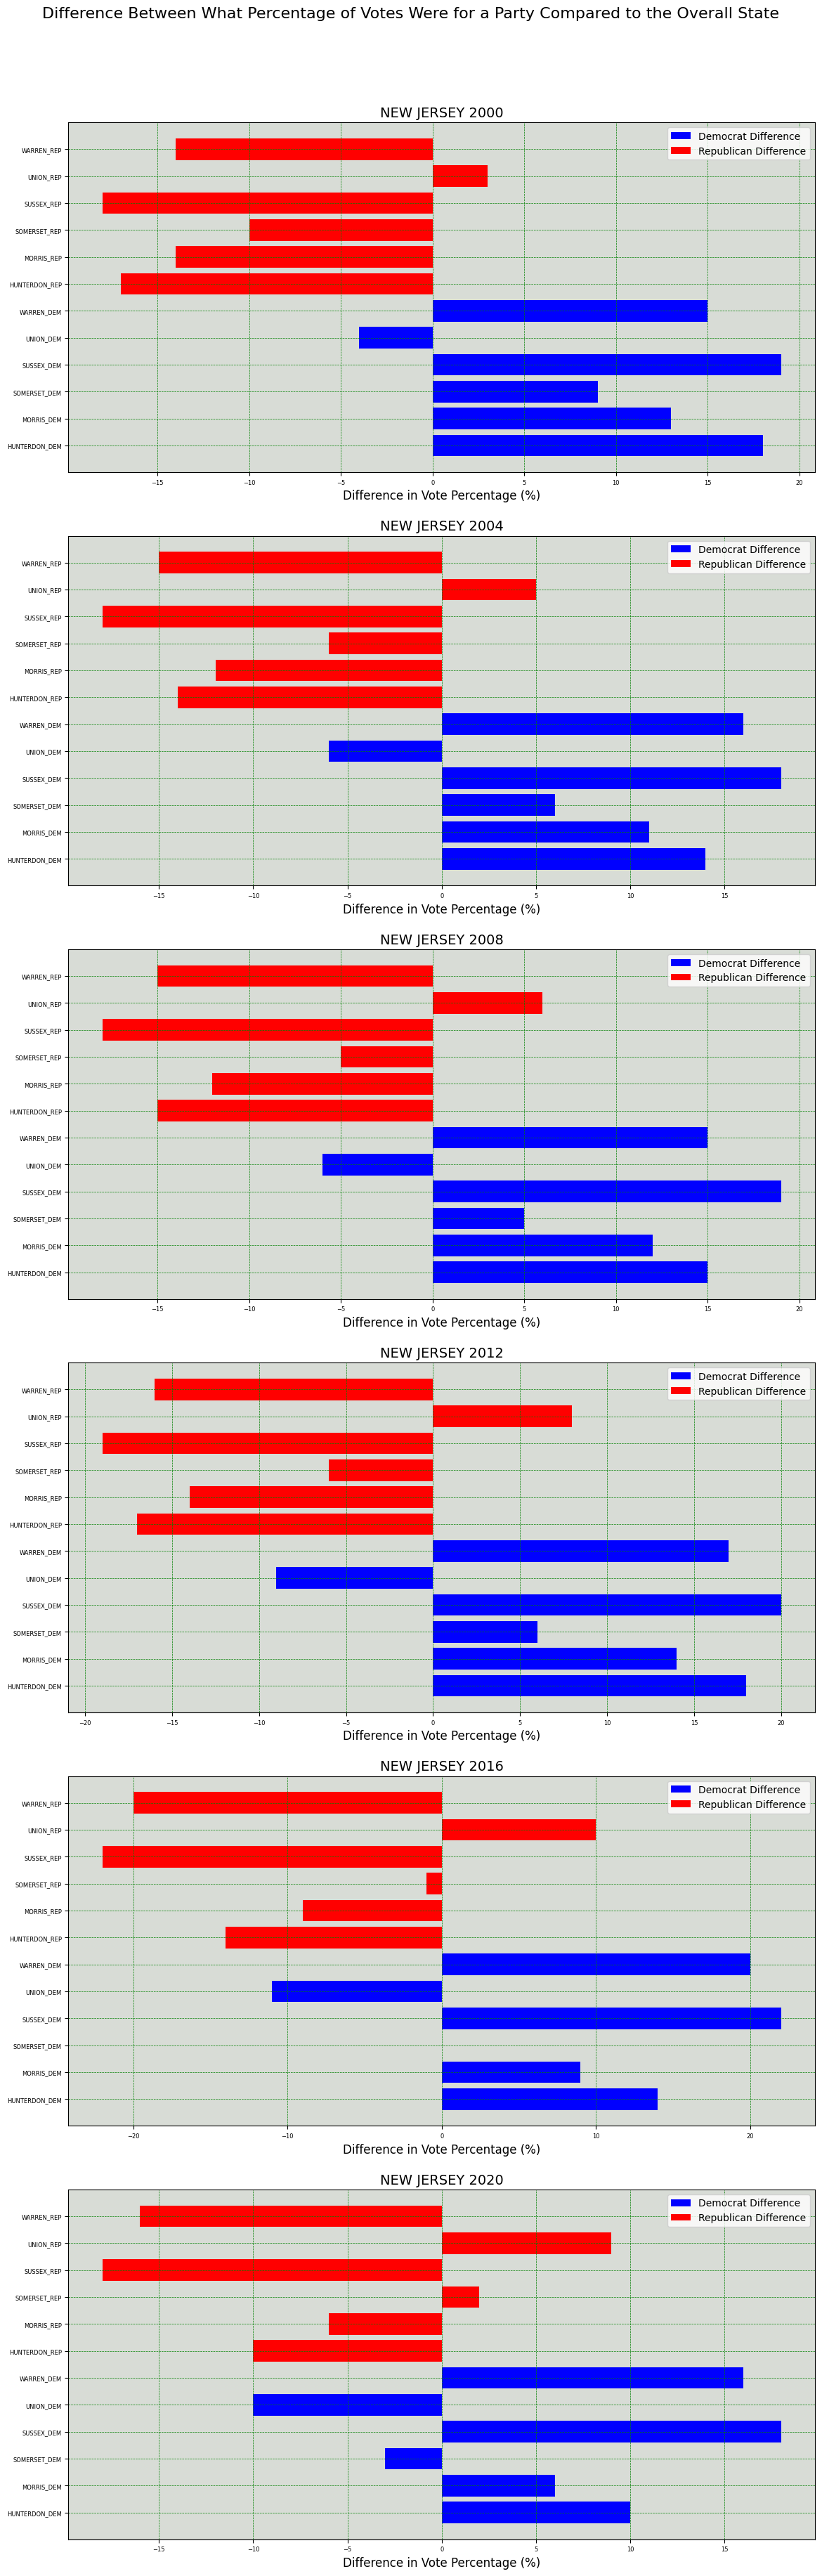

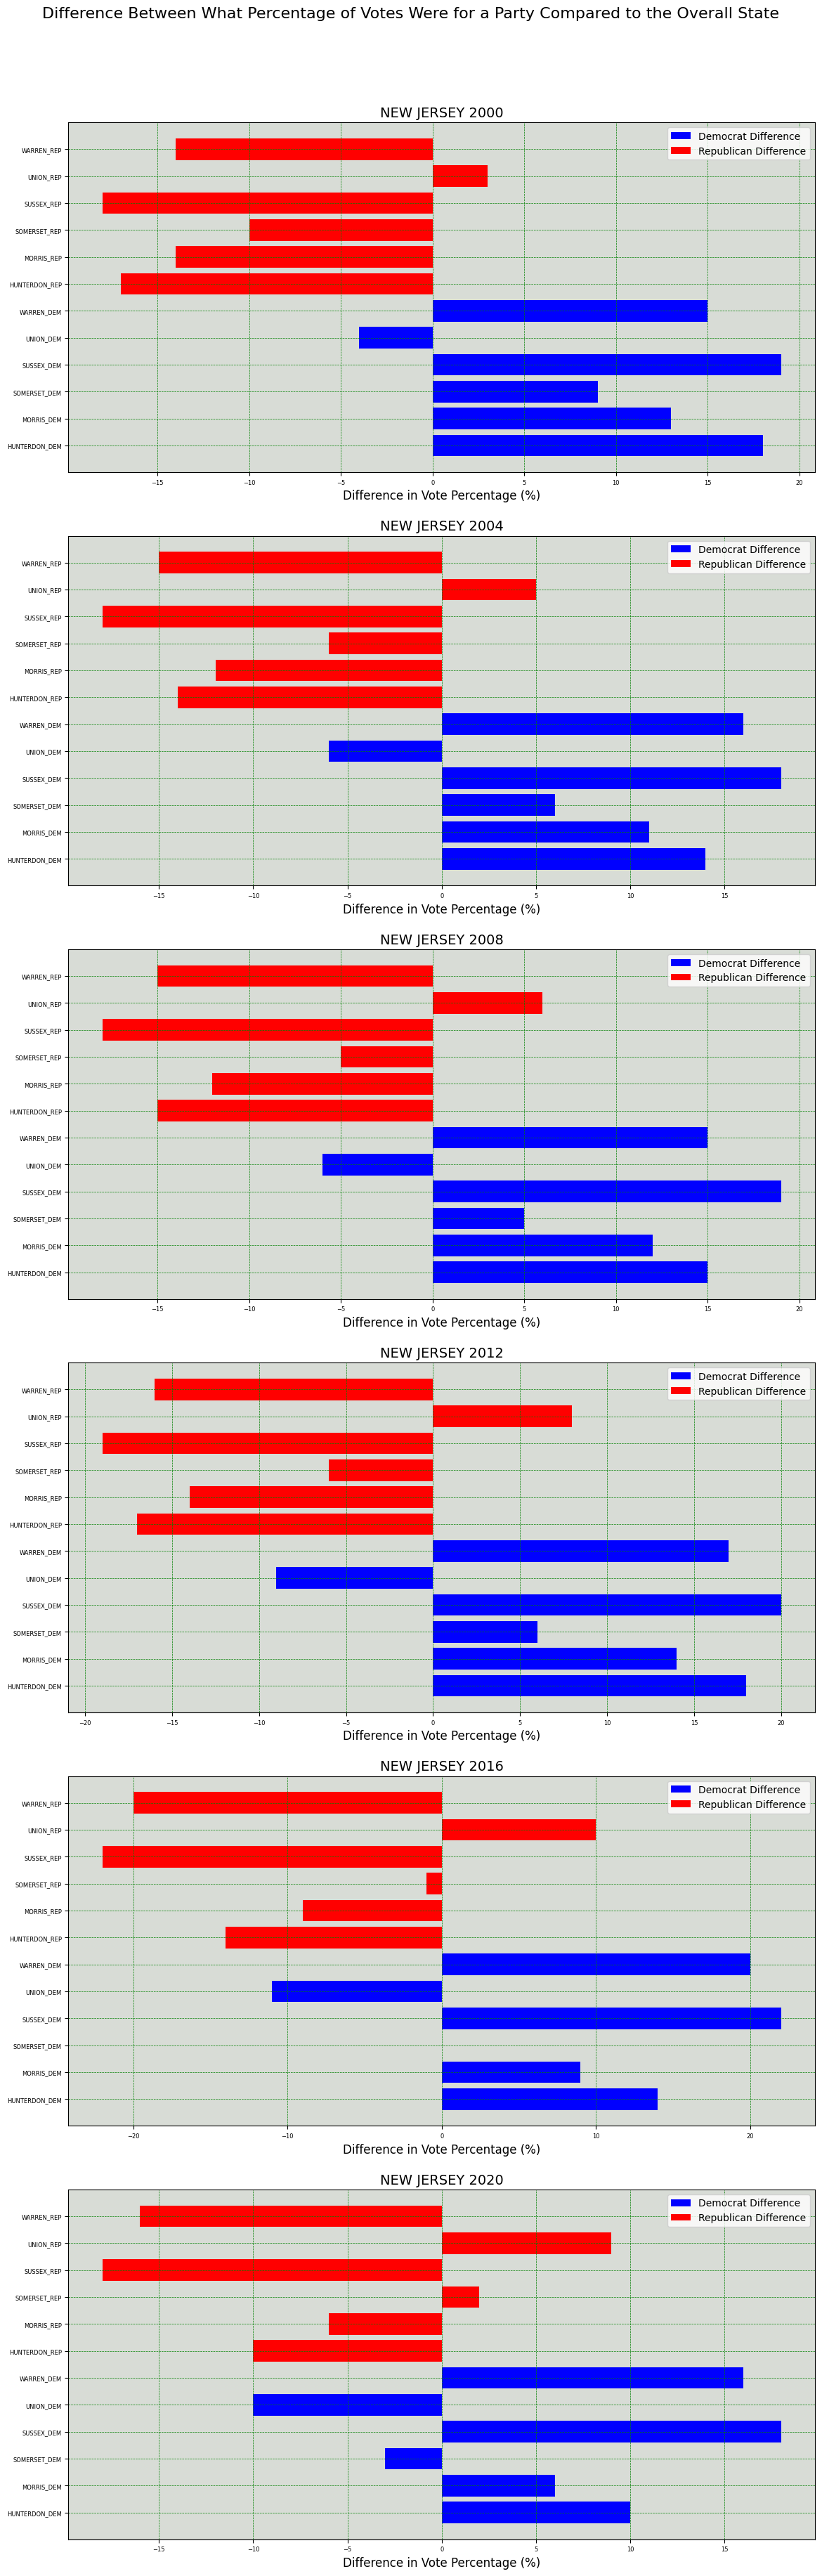

C:\Users\finof\AppData\Local\Temp\ipykernel_15524\1558074444.py:408: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(prop={'size': 6})


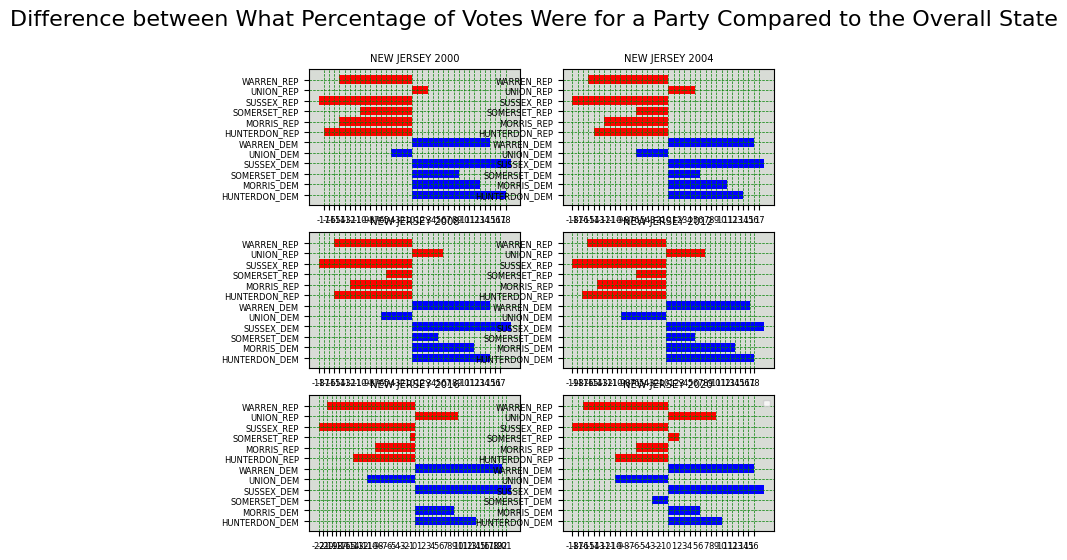

In [1]:
import os
import pandas as pd
import json
import os
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams.update({'font.size': 6})
plt.rcParams['figure.figsize'] = [6, 6]

def create_df():
    df = pd.read_csv("D:\OSNA\Project\data.csv")
    return df
    
def process_df(df):
    #Drop useless columes, rename mode -> vote_type, remove non-partisan parties
    df = df.drop(columns=['state_po', 'county_fips', 'office', 'version'])
    df = df.rename(columns={"mode" : "vote_type"})
    df.drop(df[df.party == 'GREEN'].index, inplace=True)
    df.drop(df[df.party == 'LIBERTARIAN'].index, inplace=True)
    df.drop(df[df.party == 'OTHER'].index, inplace=True)
    df = df.dropna(axis=1, how='all')

    #Define types
    df = df.astype({'year' :  str, 'state' : str, 'county_name' : str, 'candidate' : str, 'party' : str, 'candidatevotes' : int, 'totalvotes' : int, 'vote_type' : str})

    #Combine votes if vote_type is not total
    df = df.groupby(['year', 'state', 'county_name', 'candidate', 'party', 'totalvotes'], as_index=False)['candidatevotes'].sum()

    #Calculate candidates/parties vote percentage
    df['percentage'] = (df['candidatevotes']/df['totalvotes'])
    df['percentage'] = df['percentage'].round(2)
    
    return df

def group_by_states(df):
    #Get unqiue list of states and years
    years = df['year'].unique()
    states = df['state'].unique()

    #Create list (each element will be dict, see vote_dist.json)
    vote_dist = []
    
    #Loop through years
    for year in years:
        for state in states:
            #For each state get total number of votes
            total_votes_in_state = int(df.loc[(df['state'] == state) & (df['year'] == year) & (df['party'] == 'DEMOCRAT'), 'totalvotes'].sum())
            #For each state get total number of Democrat votes
            total_dem_votes_in_state = int((df.loc[(df['state'] == state) & (df['year'] == year) & (df['party'] == 'DEMOCRAT'), 'candidatevotes'].sum()))
            #For each state get total number of republican votes
            total_rep_votes_in_state = int((df.loc[(df['state'] == state) & (df['year'] == year) & (df['party'] == 'REPUBLICAN'), 'candidatevotes'].sum()))
            #Add entry for each state for each years with total votes and percentage of votes of each party
            vote_dist.append({
                'state' : state, 'year' : str(year),  
                'democrat_percent' : round(total_dem_votes_in_state/total_votes_in_state, 2),
                'republican_percent' : round(total_rep_votes_in_state/total_votes_in_state, 2),
                'total_votes' : total_votes_in_state
            })
        
        #Output to JSON
        if (os.path.isfile('vote_dist.json')): os.remove('vote_dist.json')
        with open('vote_dist.json', 'w') as fp:
            json.dump(vote_dist, fp)
            
    return vote_dist

def get_state_votes_by_year_and_state(year, state, state_votes):
    #Small function for pulling vote distribution between dems and reps for a given year and state
    state_votes_filtered_by_state = [item for item in state_votes if item["state"] == state]
    for entry in state_votes_filtered_by_state:
        if entry['year'] == year:
            #Returns dict containing year, total votes that year, Democrat percentage, Replublican percentage
            return entry

def compare_county_to_state_by_year(df, state_votes):
    state_name = 'NEW JERSEY'
    selected_counties = ['HUNTERDON', 'MORRIS', 'SOMERSET', 'SUSSEX', 'UNION', 'WARREN']  # Uppercase
    
    # Filter for selected counties
    df = df[df['county_name'].str.upper().isin(selected_counties)]  # Convert to uppercase for comparison
    
    # Validate data
    if df.empty:
        print(f"No data available for the selected counties: {selected_counties}")
        return
    
    # Get list of years to loop through
    years = df['year'].unique()
    
    # Set up figure and subplots (one column for better spacing)
    figure, axis = plt.subplots(len(years), 1, figsize=(12, len(years) * 6))
    figure.suptitle('Vote Distribution Between Democrat and Republican of Selected Counties in New Jersey', fontsize=16, y=1.02)
    
    # Loop through years
    for idx, year in enumerate(years):
        ax = axis[idx] if len(years) > 1 else axis
        
        # Separate Democrat and Republican stats for easier processing
        df_dem = df.loc[(df['party'] == 'DEMOCRAT') & (df['year'] == year) & (df['state'] == state_name)]
        df_rep = df.loc[(df['party'] == 'REPUBLICAN') & (df['year'] == year) & (df['state'] == state_name)]
        
        ## Returns dict containing year, total votes that year, Democrat percentage, Republican percentage
        state_votes_individual = get_state_votes_by_year_and_state(year, state_name, state_votes)
        
        # Prepare data for plotting
        plot_x_dem = df_dem['county_name'].tolist()
        plot_x_dem = [x + '_DEM' for x in plot_x_dem]
        plot_y_dem = df_dem['percentage'].tolist()
        
        plot_x_rep = df_rep['county_name'].tolist()
        plot_x_rep = [x + '_REP' for x in plot_x_rep]
        plot_y_rep = df_rep['percentage'].tolist()
        
        plot_x_state = [state_name + '_DEM', state_name + '_REP']
        plot_y_state = [float(state_votes_individual['democrat_percent']), float(state_votes_individual['republican_percent'])]
        
        # Plot data
        ax.barh(plot_x_state, plot_y_state, color='black', label='State Total')
        ax.barh(plot_x_dem, plot_y_dem, color='blue', label='County Democrat')
        ax.barh(plot_x_rep, plot_y_rep, color='red', label='County Republican')
        
        # Plot appearance
        ax.grid(color='green', linestyle='--', linewidth=0.5)
        ax.set_title(f'{state_name} {year}', fontsize=14)
        ax.set_xlabel('Vote Percentage', fontsize=12)
        ax.set_xlim(0, 1)
        ax.set_facecolor('xkcd:light grey')
        ax.legend(fontsize=10, loc='upper right')
        
    # Adjust layout
    plt.tight_layout(pad=3.0)
    plt.show()

    state_name = 'NEW JERSEY'
    
    # Get list of years to loop through
    years = df['year'].unique()
    
    # Set up figure and subplots (one column for better spacing)
    figure, axis = plt.subplots(len(years), 1, figsize=(12, len(years) * 6))  # Increase figure size dynamically
    figure.suptitle('Vote Distribution Between Democrat and Republican of a state and its counties', fontsize=16, y=1.02)
    
    # Loop through years
    for idx, year in enumerate(years):
        ax = axis[idx] if len(years) > 1 else axis  # Handle case where only one subplot exists
        
        # Separate Democrat and Republican stats for easier processing
        df_dem = df.loc[(df['party'] == 'DEMOCRAT') & (df['year'] == year) & (df['state'] == state_name)]
        df_rep = df.loc[(df['party'] == 'REPUBLICAN') & (df['year'] == year) & (df['state'] == state_name)]
        
        ## Returns dict containing year, total votes that year, Democrat percentage, Replublican percentage
        state_votes_individual = get_state_votes_by_year_and_state(year, state_name, state_votes)
        
        # Prepare data for plotting
        plot_x_dem = df_dem['county_name'].tolist()
        plot_x_dem = [x + '_DEM' for x in plot_x_dem]
        plot_y_dem = df_dem['percentage'].tolist()
        
        plot_x_rep = df_rep['county_name'].tolist()
        plot_x_rep = [x + '_REP' for x in plot_x_rep]
        plot_y_rep = df_rep['percentage'].tolist()
        
        plot_x_state = [state_name + '_DEM', state_name + '_REP']
        plot_y_state = [float(state_votes_individual['democrat_percent']), float(state_votes_individual['republican_percent'])]
        
        # Plot data
        ax.barh(plot_x_state, plot_y_state, color='black', label='State Total')
        ax.barh(plot_x_dem, plot_y_dem, color='blue', label='County Democrat')
        ax.barh(plot_x_rep, plot_y_rep, color='red', label='County Republican')
        
        # Plot appearance
        ax.grid(color='green', linestyle='--', linewidth=0.5)
        ax.set_title(f'{state_name} {year}', fontsize=14)
        ax.set_xlabel('Vote Percentage', fontsize=12)
        ax.set_xlim(0, 1)
        ax.set_facecolor('xkcd:light grey')
        ax.legend(fontsize=10, loc='upper right')
        
    # Adjust layout
    plt.tight_layout(pad=3.0)
    plt.show()

    state_name = 'NEW JERSEY'  # Updated state name
    
    #Get list of years to loop through
    years = df['year'].unique()
    
    #Co-ordinates for subplots
    x, y = 0, 0
    
    #Setup figure + sublpots
    figure, axis = plt.subplots(3, 2)
    figure.suptitle('Vote Distribution Between Democrat and Republican of a state and its counties', fontsize=16)
    
    #Loop though years
    for year in years:
        #Separate Democrat and Republican stats for easier processing
        df_dem = df.loc[(df['party'] == 'DEMOCRAT') & (df['year'] == year) & (df['state'] == state_name)]
        df_rep = df.loc[(df['party'] == 'REPUBLICAN') & (df['year'] == year) & (df['state'] == state_name)]
        
        ##Returns dict containing year, total votes that year, Democrat percentage, Replublican percentage
        state_votes_individual = get_state_votes_by_year_and_state(year, state_name, state_votes)
        
        # Get list of county names and add _DEM to it
        plot_x_dem = df_dem['county_name'].tolist()
        plot_x_dem = [x + '_DEM' for x in plot_x_dem]
        # Get list of percentage values
        plot_y_dem = df_dem['percentage'].tolist()
        
        # Get list of county names and add _REP to it
        plot_x_rep = df_rep['county_name'].tolist()
        plot_x_rep = [x + '_REP' for x in plot_x_rep]
        # Get list of percentage values
        plot_y_rep = df_rep['percentage'].tolist()
        
        # Create another series of 2 data points - vote distribution of parties on state level
        plot_x_state = [state_name + '_DEM', state_name + '_REP']
        plot_y_state = [float(state_votes_individual['democrat_percent']), float(state_votes_individual['republican_percent'])]
        
        # Plot series for state data
        axis[x, y].barh(plot_x_state, plot_y_state, color = 'Black')
        
        # Plot series for Democrat data
        axis[x, y].barh(plot_x_dem, plot_y_dem, color ='Blue')
        
        # Plot series for Republican data
        axis[x, y].barh(plot_x_rep, plot_y_rep, color = 'Red')
        
        # Plot appearance
        axis[x, y].grid(color = 'green', linestyle = '--', linewidth = 0.5)
        axis[x, y].set_title(state_name + ' ' + year)
        xticks = np.arange(0.0, 1.1, 0.1)
        xlabels = [str(round(x, 1)) for x in xticks]
        axis[x, y].set_xticks(xticks, labels=xlabels)
        axis[x, y].set_facecolor('xkcd:light grey')
        
        # Logic for incrementing co-ordinates of next subplot (0,0 - 0,1 - 1,0 - 1,1 etc.)
        if y == 0:
            y = y + 1
        elif y == 1:
            x = x + 1
            y = 0
    
    # Plot appearance
    plt.xlabel("State/County")
    plt.legend(prop={'size': 6})
    plt.show(block=False)

def compare_county_to_state_difference(df, state_votes):
    state_name = 'NEW JERSEY'
    selected_counties = ['HUNTERDON', 'MORRIS', 'SOMERSET', 'SUSSEX', 'UNION', 'WARREN']
    
    # Filter for selected counties
    df = df[df['county_name'].isin(selected_counties)]
    
    # Get list of years to loop through
    years = df['year'].unique()
    
    # Set up figure and subplots (one column for better spacing)
    figure, axis = plt.subplots(len(years), 1, figsize=(12, len(years) * 6))
    figure.suptitle('Difference Between What Percentage of Votes Were for a Party Compared to the Overall State', fontsize=16, y=1.02)
    
    # Loop through years
    for idx, year in enumerate(years):
        ax = axis[idx] if len(years) > 1 else axis
        
        # Separate Democrat and Republican stats for easier processing
        df_dem = df.loc[(df['party'] == 'DEMOCRAT') & (df['year'] == year) & (df['state'] == state_name)]
        df_rep = df.loc[(df['party'] == 'REPUBLICAN') & (df['year'] == year) & (df['state'] == state_name)]
        
        # Get state-level vote percentages
        state_votes_for_year = get_state_votes_by_year_and_state(year, state_name, state_votes)
        total_dem_votes = float(state_votes_for_year['democrat_percent'])
        total_rep_votes = float(state_votes_for_year['republican_percent'])
        
        # Calculate differences
        plot_x_dem = df_dem['county_name'].tolist()
        plot_x_dem = [x + '_DEM' for x in plot_x_dem]
        plot_y_dem = [(total_dem_votes - x) * 100 for x in df_dem['percentage'].tolist()]
        
        plot_x_rep = df_rep['county_name'].tolist()
        plot_x_rep = [x + '_REP' for x in plot_x_rep]
        plot_y_rep = [(total_rep_votes - x) * 100 for x in df_rep['percentage'].tolist()]
        
        # Plot data
        ax.barh(plot_x_dem, plot_y_dem, color='blue', label='Democrat Difference')
        ax.barh(plot_x_rep, plot_y_rep, color='red', label='Republican Difference')
        
        # Plot appearance
        ax.grid(color='green', linestyle='--', linewidth=0.5)
        ax.set_title(f'{state_name} {year}', fontsize=14)
        ax.set_xlabel('Difference in Vote Percentage (%)', fontsize=12)
        ax.set_facecolor('xkcd:light grey')
        ax.legend(fontsize=10, loc='upper right')
        
    # Adjust layout
    plt.tight_layout(pad=3.0)
    plt.show()

    state_name = 'NEW JERSEY'
    
    # Get list of years to loop through
    years = df['year'].unique()
    
    # Set up figure and subplots (one column for better spacing)
    figure, axis = plt.subplots(len(years), 1, figsize=(12, len(years) * 6))  # Increase figure size dynamically
    figure.suptitle('Difference Between What Percentage of Votes Were for a Party Compared to the Overall State', fontsize=16, y=1.02)
    
    # Loop through years
    for idx, year in enumerate(years):
        ax = axis[idx] if len(years) > 1 else axis  # Handle case where only one subplot exists
        
        # Separate Democrat and Republican stats for easier processing
        df_dem = df.loc[(df['party'] == 'DEMOCRAT') & (df['year'] == year) & (df['state'] == state_name)]
        df_rep = df.loc[(df['party'] == 'REPUBLICAN') & (df['year'] == year) & (df['state'] == state_name)]
        
        # Get state-level vote percentages
        state_votes_for_year = get_state_votes_by_year_and_state(year, state_name, state_votes)
        total_dem_votes = float(state_votes_for_year['democrat_percent'])
        total_rep_votes = float(state_votes_for_year['republican_percent'])
        
        # Calculate differences
        plot_x_dem = df_dem['county_name'].tolist()
        plot_x_dem = [x + '_DEM' for x in plot_x_dem]
        plot_y_dem = [(total_dem_votes - x) * 100 for x in df_dem['percentage'].tolist()]
        
        plot_x_rep = df_rep['county_name'].tolist()
        plot_x_rep = [x + '_REP' for x in plot_x_rep]
        plot_y_rep = [(total_rep_votes - x) * 100 for x in df_rep['percentage'].tolist()]
        
        # Plot data
        ax.barh(plot_x_dem, plot_y_dem, color='blue', label='Democrat Difference')
        ax.barh(plot_x_rep, plot_y_rep, color='red', label='Republican Difference')
        
        # Plot appearance
        ax.grid(color='green', linestyle='--', linewidth=0.5)
        ax.set_title(f'{state_name} {year}', fontsize=14)
        ax.set_xlabel('Difference in Vote Percentage (%)', fontsize=12)
        ax.set_facecolor('xkcd:light grey')
        ax.legend(fontsize=10, loc='upper right')
        
    # Adjust layout
    plt.tight_layout(pad=3.0)
    plt.show()

    state_name = 'NEW JERSEY'  # Updated state name
    
    #Get list of years to loop through
    years = df['year'].unique()
    
    #Co-ordinates for subplots
    x, y = 0, 0
    
    #Setup figure + sublpots
    figure, axis = plt.subplots(3, 2)
    figure.suptitle('Difference between What Percentage of Votes Were for a Party Compared to the Overall State', fontsize=16)
    
    #Loop though years
    for year in years:
        #Separate Democrat and Republican stats for easier processing
        df_dem = df.loc[(df['party'] == 'DEMOCRAT') & (df['year'] == year) & (df['state'] == state_name)]
        df_rep = df.loc[(df['party'] == 'REPUBLICAN') & (df['year'] == year) & (df['state'] == state_name)]
        
        #Returns dict containing year, total votes that year, Democrat percentage, Replublican percentage
        state_votes_for_year = get_state_votes_by_year_and_state(year, state_name, state_votes)
        
        # Get list of county names and add _DEM to it
        plot_x_dem = df_dem['county_name'].tolist()
        plot_x_dem = [x + '_DEM' for x in plot_x_dem]
        
        # Get list of county names and add _REP to it
        plot_x_rep = df_rep['county_name'].tolist()
        plot_x_rep = [x + '_REP' for x in plot_x_rep]
        
        # Gets percentage of votes for Democrats and Republicans at state level
        total_dem_votes = float(state_votes_for_year['democrat_percent'])
        total_rep_votes = float(state_votes_for_year['republican_percent'])
        
        # Gets list of percentage of votes for each party (one entry for each county), then subtracts it from what the party achieved at state level
        plot_y_dem = df_dem['percentage'].tolist()
        plot_y_dem = [(total_dem_votes - x)*100 for x in plot_y_dem]
        plot_y_rep = df_rep['percentage'].tolist()
        plot_y_rep = [(total_rep_votes - x)*100 for x in plot_y_rep]

        # Plot Democrat and Republican stats
        axis[x, y].barh(plot_x_dem, plot_y_dem, color ='Blue')
        axis[x, y].barh(plot_x_rep, plot_y_rep, color = 'Red')
        
        # Plot appearance
        axis[x, y].grid(color = 'green', linestyle = '--', linewidth = 0.5)
        axis[x, y].set_title(state_name + ' ' + year)
        min_value = min(plot_y_dem + plot_y_rep)
        max_value = max(plot_y_dem + plot_y_rep)
        xticks = np.arange(int(min_value), int(max_value), 1)
        xlabels = [str(x) for x in xticks]
        axis[x, y].set_xticks(xticks, labels=xlabels)
        axis[x, y].set_facecolor('xkcd:light grey')

        # Logic for incrementing co-ordinates of next subplot (0,0 - 0,1 - 1,0 - 1,1 etc.)
        if y == 0:
            y = y + 1
        elif y == 1:
            
            x = x + 1
            y = 0
            
    # Plot appearance
    plt.legend(prop={'size': 6})
    plt.show(block=False)

    #if (os.path.isfile('2.png')): os.remove('2.png')
    #figure.savefig('2.png')
        
        
        
    

def main():
    #Create DF from CSV
    df = create_df()
    
    #Process/satinize df
    df = process_df(df)
    
    #Sumarize votes by year and county for each state - see vote_dist.json
    state_votes = group_by_states(df)
    
    #Compare vote distribution between between a given county compared to its state for a given year
    compare_county_to_state_by_year(df, state_votes)
    
    #Difference Between What Percentage of Votes Were for a Party Compared to the Overall State
    compare_county_to_state_difference(df, state_votes)
    
    pause = input("Press Enter to exit")


if __name__ == '__main__':
    main()

## Historical Voter Turnout Trends in NJ 7th

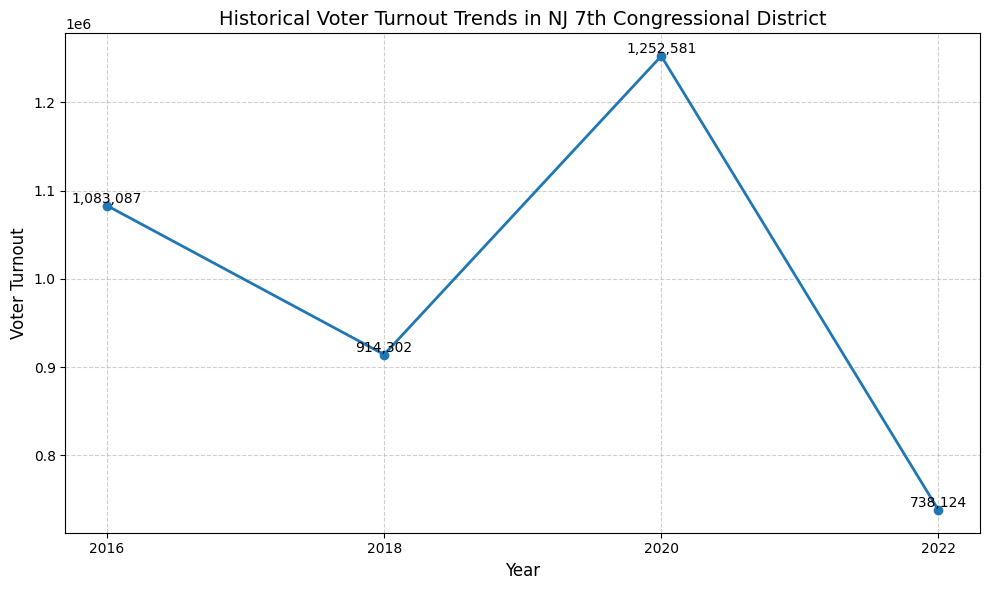

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Data extracted for NJ 7th Congressional District
nj7_data = {
    "County": ["Essex", "Hunterdon", "Morris", "Somerset", "Union", "Warren"],
    "2016": [316111, 72709, 256517, 160545, 226793, 50412],
    "2018": [260222, 64285, 221193, 138293, 188734, 41575],
    "2020": [351931, 85107, 305874, 189727, 258344, 61598],
    "2022": [180172, 61059, 194387, 118909, 144287, 39310],
}

# Create a DataFrame for easier calculations
df = pd.DataFrame(nj7_data)

# Calculate the total voter turnout for each year
years = ["2016", "2018", "2020", "2022"]
turnout_data = df[["2016", "2018", "2020", "2022"]].sum().values

# Plotting the voter turnout trends
plt.figure(figsize=(10, 6))
plt.plot(years, turnout_data, marker='o', linestyle='-', linewidth=2)

# Adding labels and title
plt.title("Historical Voter Turnout Trends in NJ 7th Congressional District", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Voter Turnout", fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.6)

# Adding data points for clarity
for i, turnout in enumerate(turnout_data):
    plt.text(years[i], turnout, f"{turnout:,}", ha='center', va='bottom', fontsize=10)

# Show the plot
plt.tight_layout()
plt.show()


## Party Registration & 2020 Voter Turnout by County in NJ 7th

Voter Registration 2024 Columns: Index(['Districts', 'UNA', 'DEM', 'REP', 'CNV', 'CON', 'GRE', 'LIB', 'NAT',
       'RFP', 'SSP', 'Total'],
      dtype='object')


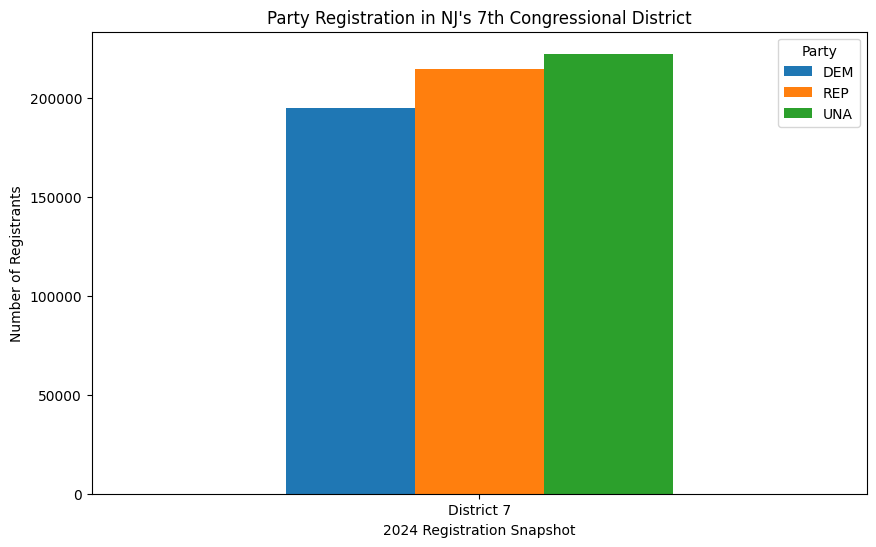

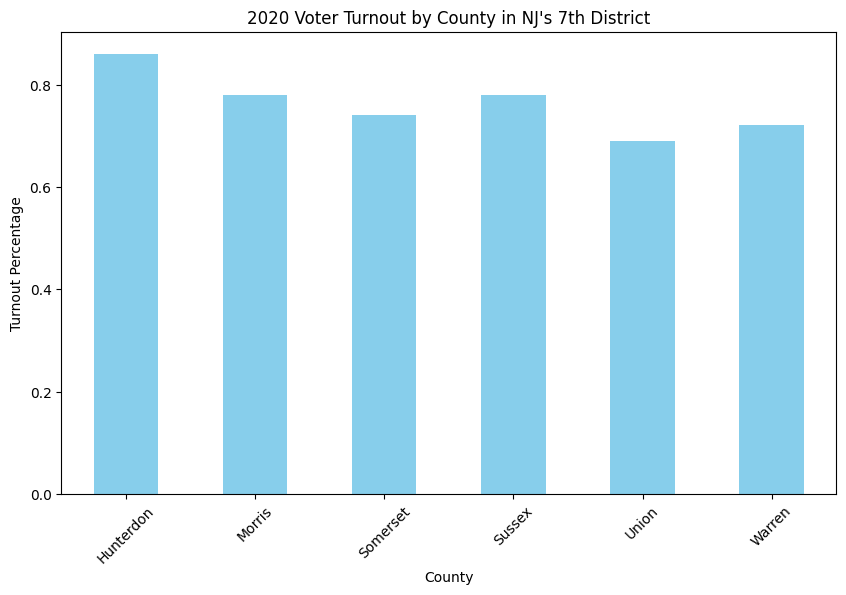

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
voter_registration_2024_df = pd.read_excel(r'D:\OSNA\Project\2024 General Election Day Voter Registration by Congressional Voting District.xlsx')
voter_turnout_2020_df = pd.read_excel("D:/OSNA/Project/2020-official-general-voter-turnout.xlsx")

# Analyze voter registration data for NJ's 7th District
print("Voter Registration 2024 Columns:", voter_registration_2024_df.columns)
district_7_reg = voter_registration_2024_df[voter_registration_2024_df['Districts'] == '07']
if not district_7_reg.empty:
    # Creating separate bars for each party registration
    district_7_reg[['DEM', 'REP', 'UNA']].plot(kind='bar', figsize=(10, 6))
    plt.title('Party Registration in NJ\'s 7th Congressional District')
    plt.ylabel('Number of Registrants')
    plt.xlabel('2024 Registration Snapshot')
    plt.xticks(ticks=[0], labels=['District 7'], rotation=0)  # Assuming only one row for District 7
    plt.legend(title='Party')
    plt.show()

# Voter turnout in 2020 for specified counties
relevant_counties = ['Hunterdon', 'Morris', 'Somerset', 'Sussex', 'Union', 'Warren']  
turnout_2020 = voter_turnout_2020_df[voter_turnout_2020_df['COUNTY'].isin(relevant_counties)]
if not turnout_2020.empty:
    turnout_2020.set_index('COUNTY')['Percent of Ballots Cast'].plot(kind='bar', color='skyblue', figsize=(10, 6))
    plt.title('2020 Voter Turnout by County in NJ\'s 7th District')
    plt.ylabel('Turnout Percentage')
    plt.xlabel('County')
    plt.xticks(rotation=45)
    plt.show()
else:
    print("No data available for specified counties.")

## Voting Trends by Age in NJ 7th

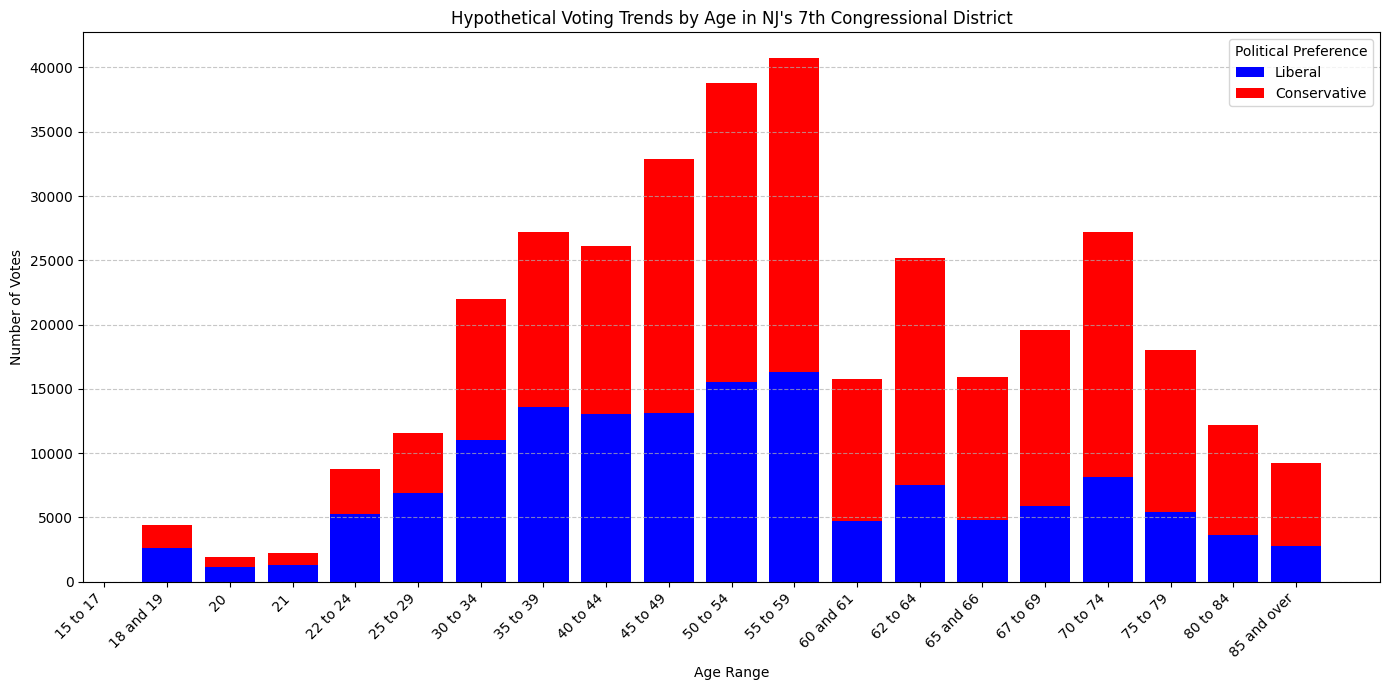

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
population_age_df = pd.read_csv("C:/Users/finof/Downloads/population by age range.csv")


# Filter for Congressional District 7, NJ data
district_7_population_age = population_age_df[population_age_df['name'] == 'Congressional District 7, NJ']

# Summing male and female counts for each age group
age_columns = [col for col in district_7_population_age.columns if 'years' in col or 'Years' in col]
male_age_columns = age_columns[:len(age_columns)//2]
female_age_columns = age_columns[len(age_columns)//2:]
corrected_female_age_columns = [col.replace('.1', '') for col in female_age_columns]

# Creating a new dataframe for visualization
age_distribution = pd.DataFrame()
age_distribution['Age Range'] = [col.replace(' years', '').replace(' Years', '').strip() for col in male_age_columns]
age_distribution['Population'] = district_7_population_age[male_age_columns].iloc[0].values + district_7_population_age[corrected_female_age_columns].iloc[0].values

# Assumed turnout rates and voting preferences by age group
turnout_rates = {
    'Under 5': 0, '5 to 9': 0, '10 to 14': 0, '15 to 17': 0, # Non-voting ages
    '18 and 19': 0.30, '20': 0.30, '21': 0.30, '22 to 24': 0.30,
    '25 to 29': 0.30, '30 to 34': 0.50, '35 to 39': 0.50,
    '40 to 44': 0.50, '45 to 49': 0.65, '50 to 54': 0.65,
    '55 to 59': 0.65, '60 and 61': 0.75, '62 to 64': 0.75,
    '65 and 66': 0.75, '67 to 69': 0.75, '70 to 74': 0.75,
    '75 to 79': 0.75, '80 to 84': 0.75, '85 and over': 0.75
}

# Assumed voting preferences
liberal_preferences = {
    '18 and 19': 0.60, '20': 0.60, '21': 0.60, '22 to 24': 0.60,
    '25 to 29': 0.60, '30 to 34': 0.50, '35 to 39': 0.50,
    '40 to 44': 0.50, '45 to 49': 0.40, '50 to 54': 0.40,
    '55 to 59': 0.40, '60 and 61': 0.30, '62 to 64': 0.30,
    '65 and 66': 0.30, '67 to 69': 0.30, '70 to 74': 0.30,
    '75 to 79': 0.30, '80 to 84': 0.30, '85 and over': 0.30
}

# Calculate potential voters
age_distribution['Potential Voters'] = age_distribution['Population'] * age_distribution['Age Range'].map(turnout_rates)
age_distribution['Liberal Votes'] = age_distribution['Potential Voters'] * age_distribution['Age Range'].map(liberal_preferences)
age_distribution['Conservative Votes'] = age_distribution['Potential Voters'] - age_distribution['Liberal Votes']

# Visualization
fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(age_distribution['Age Range'], age_distribution['Liberal Votes'], label='Liberal', color='blue')
ax.bar(age_distribution['Age Range'], age_distribution['Conservative Votes'], bottom=age_distribution['Liberal Votes'], label='Conservative', color='red')
ax.set_xlabel('Age Range')
ax.set_ylabel('Number of Votes')
ax.set_title('Voting Trends by Age in NJ\'s 7th Congressional District')
ax.legend(title='Political Preference')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

## Comparison of Citizen Voting Age Population and Voter Registration in November 2024

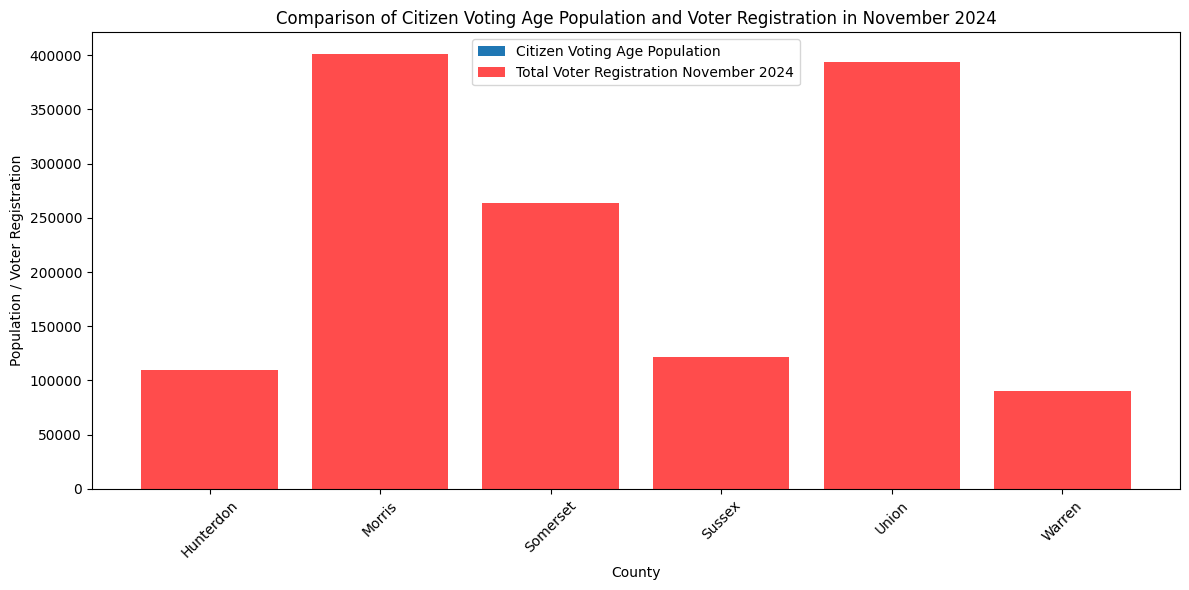

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load datasets
voter_reg_2024_gen = pd.read_excel('D:/OSNA/Project/2024 General Election Day Voter Registration by County.xlsx')
voter_reg_2024_nov = pd.read_excel('D:/OSNA/Project/November 2024 Voter Registration by County.xlsx')
voter_turnout_2020 = pd.read_excel('D:/OSNA/Project/2020-official-general-voter-turnout.xlsx')
cvap_data = pd.read_csv('D:/OSNA/Project/nj_cvap_2021_cnty/nj_cvap_2021_cnty.csv')

# Define the counties in NJ's 7th Congressional District
nj7_counties = ['Hunterdon', 'Morris', 'Somerset', 'Sussex', 'Union', 'Warren']

# Adjusting column names in the filters
voter_reg_2024_gen = voter_reg_2024_gen[voter_reg_2024_gen['County'].isin(nj7_counties)]
voter_reg_2024_nov = voter_reg_2024_nov[voter_reg_2024_nov['County'].isin(nj7_counties)]
voter_turnout_2020 = voter_turnout_2020[voter_turnout_2020['COUNTY'].isin(nj7_counties)]
cvap_data = cvap_data[cvap_data['COUNTY'].isin(nj7_counties)]

# Example visualization: Comparing voter registration in November 2024 to CVAP data
plt.figure(figsize=(12, 6))
plt.bar(cvap_data['COUNTY'], cvap_data['C_TOT21'], color='blue', label='Citizen Voting Age Population')
plt.bar(voter_reg_2024_nov['County'], voter_reg_2024_nov['Total'], color='red', alpha=0.7, label='Total Voter Registration November 2024')
plt.xlabel('County')
plt.ylabel('Population / Voter Registration')
plt.title('Comparison of Citizen Voting Age Population and Voter Registration in November 2024')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


## Absolute Decrease in Voter Registration by Party in NJ-7 Counties

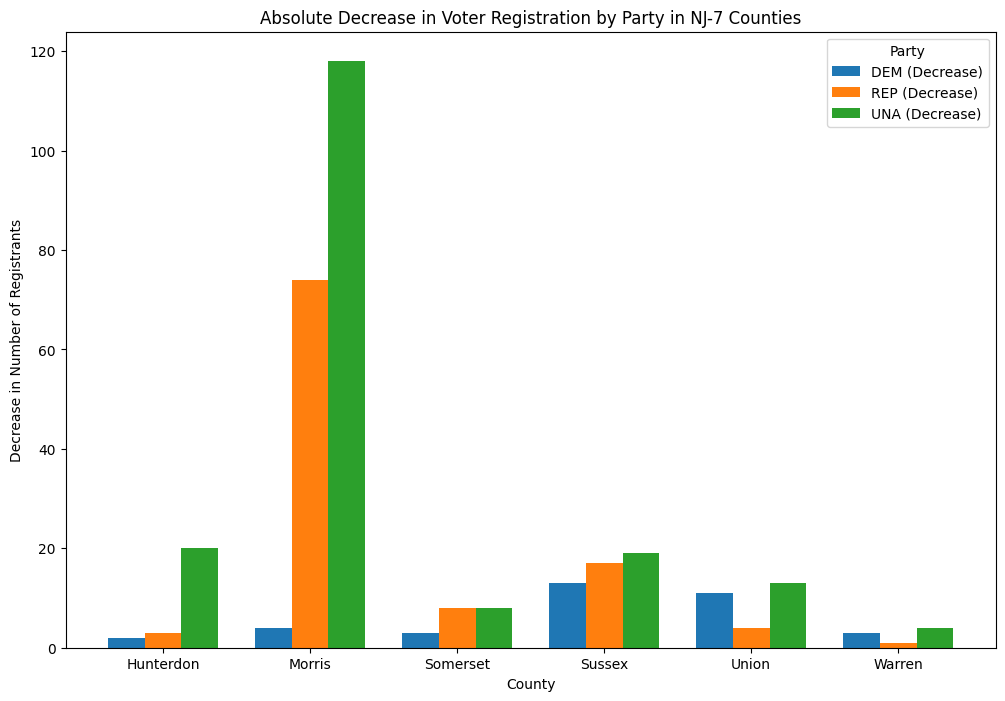

In [5]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load the datasets
data_2024_voter_reg_gen = pd.read_excel('D:/OSNA/Project/2024 General Election Day Voter Registration by County.xlsx')
data_2024_voter_reg_nov = pd.read_excel('D:/OSNA/Project/November 2024 Voter Registration by County.xlsx')

# Define the counties in NJ's 7th Congressional District
counties_in_nj7 = ['Hunterdon', 'Morris', 'Somerset', 'Sussex', 'Union', 'Warren']

# Filter the 2024 General Election Day and November voter registration data for NJ-7 counties
gen_election_day_nj7 = data_2024_voter_reg_gen[data_2024_voter_reg_gen['County'].isin(counties_in_nj7)]
november_nj7 = data_2024_voter_reg_nov[data_2024_voter_reg_nov['County'].isin(counties_in_nj7)]

# Calculate changes in voter registration by subtracting General Election Day data from November data
registration_changes_nj7 = november_nj7.set_index('County').subtract(gen_election_day_nj7.set_index('County'), fill_value=0)

# Reset index to bring 'County' back as a column and sort by county names for visualization
registration_changes_nj7 = registration_changes_nj7.reset_index().sort_values(by='County')

# Convert changes to their absolute values for visualization
registration_changes_nj7['DEM'] = registration_changes_nj7['DEM'].abs()
registration_changes_nj7['REP'] = registration_changes_nj7['REP'].abs()
registration_changes_nj7['UNA'] = registration_changes_nj7['UNA'].abs()

# Visualization using grouped bar chart
fig, ax = plt.subplots(figsize=(12, 8))
width = 0.25  # Width of the bars

# Positions of the bars
positions = range(len(registration_changes_nj7['County']))

# Plotting each party's registration change as absolute values
ax.bar([p - width for p in positions], registration_changes_nj7['DEM'], width, label='DEM (Decrease)')
ax.bar(positions, registration_changes_nj7['REP'], width, label='REP (Decrease)')
ax.bar([p + width for p in positions], registration_changes_nj7['UNA'], width, label='UNA (Decrease)')

# Adding labels and title
ax.set_title('Absolute Decrease in Voter Registration by Party in NJ-7 Counties')
ax.set_xlabel('County')
ax.set_ylabel('Decrease in Number of Registrants')
ax.set_xticks(positions)
ax.set_xticklabels(registration_changes_nj7['County'])
ax.legend(title='Party')

plt.show()


Explanation of the Plot
Title and Labels:

The title, "Absolute Decrease in Voter Registration by Party in NJ-7 Counties," indicates that the bars represent the magnitude of decrease in voter registration.
The y-axis shows the "Decrease in Number of Registrants," which represents the count of voter registrations that have dropped for each political affiliation.
The x-axis lists each of the counties within NJ's 7th Congressional District (Hunterdon, Morris, Somerset, Sussex, Union, and Warren).
Color Coding:

Blue: Democratic Party (DEM)
Orange: Republican Party (REP)
Green: Unaffiliated (UNA)
Each color-coded bar shows the decrease in voter registrations for that party within each county.
County-Level Insights:

Morris County: Shows the most significant decrease in voter registrations, with a large drop in both Republican and Unaffiliated registrations. This suggests that voter engagement in these groups declined significantly compared to other counties.
Sussex County: Also shows a noticeable decrease across all three affiliations, but on a smaller scale than Morris County.
Hunterdon and Warren Counties: These counties show minor decreases, primarily in Unaffiliated voters, suggesting more stability in voter registration for this period.
Union County: Shows decreases in all affiliations but also has some stability compared to counties like Morris.
Somerset County: Has small decreases in Democratic and Republican registrations, with a minor impact on the overall registration.
Interpretation:

The differences in decreases suggest that certain counties (like Morris and Sussex) might be experiencing factors that lead to more significant voter registration drops (such as relocations, voter roll maintenance, or demographic shifts).
The Unaffiliated (green bars) group often shows more substantial decreases compared to the Democratic or Republican groups, possibly due to demographic changes or disinterest among non-affiliated voters.

## Voter Turnout Trend Analysis

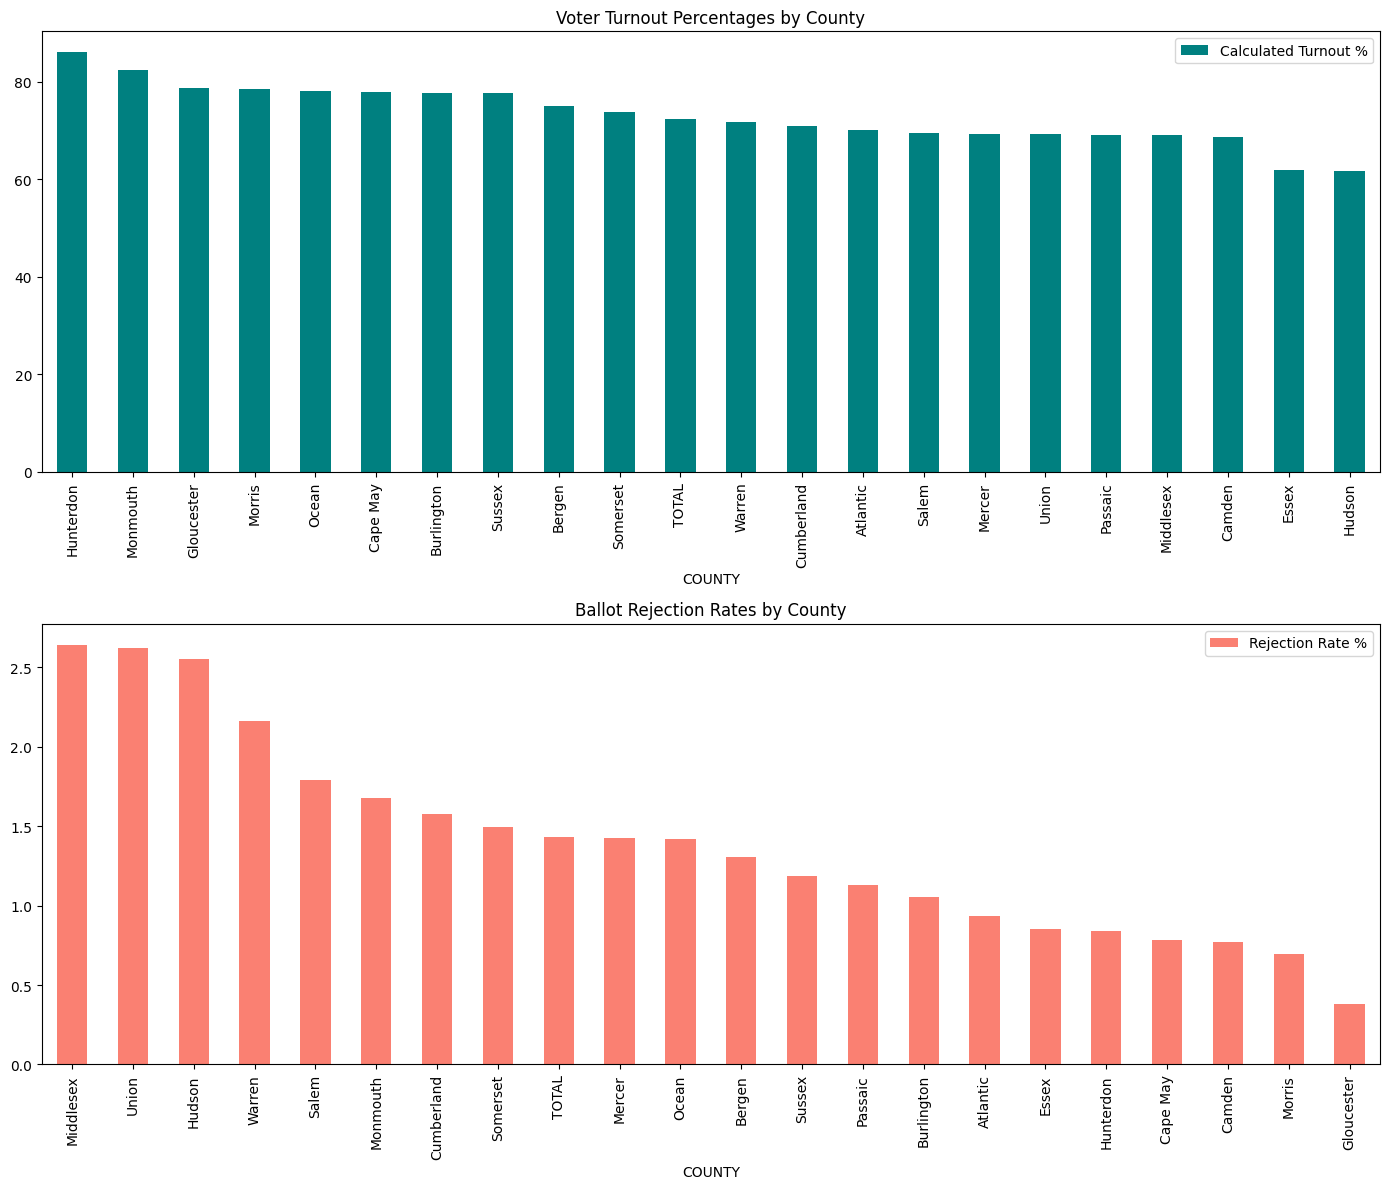

In [6]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt

# Load your data into a Pandas DataFrame
# Replace 'path/to/your/dataset.xlsx' with the actual file path
data = pd.read_excel('D:/OSNA/Project/2020-official-general-voter-turnout.xlsx')

# Correct any column name discrepancies and ensure correct data types
data['Total Number of Registered Voters'] = data['Total Number of Registered Voters '].astype(float)
data['Total Number of Ballots Cast'] = data['Total Number of Ballots Cast'].astype(float)
data['Total Number of Ballots Rejected'] = data['Total Number of Ballots Rejected'].astype(float)

# Calculate additional metrics
data['Calculated Turnout %'] = (data['Total Number of Ballots Cast'] / data['Total Number of Registered Voters']) * 100
data['Rejection Rate %'] = (data['Total Number of Ballots Rejected'] / data['Total Number of Ballots Cast']) * 100

# Create a figure to hold the plots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(14, 12))

# Bar Chart for Voter Turnout Percentages by County
data.sort_values(by='Calculated Turnout %', ascending=False).plot(x='COUNTY', y='Calculated Turnout %', kind='bar', ax=axes[0], color='teal', title='Voter Turnout Percentages by County')

# Bar Chart for Ballot Rejection Rates by County
data.sort_values(by='Rejection Rate %', ascending=False).plot(x='COUNTY', y='Rejection Rate %', kind='bar', ax=axes[1], color='salmon', title='Ballot Rejection Rates by County')

# Enhance layout
plt.tight_layout()
plt.show()


Here are the visualizations that illustrate voter turnout trends:

Voter Turnout Percentages by County (Top Chart): This bar chart displays the turnout percentages calculated for each county, sorted from highest to lowest. This helps us see which counties had the highest and lowest voter participation in the election.

Ballot Rejection Rates by County (Bottom Chart): This bar chart shows the percentage of ballots rejected in each county, also sorted from highest to lowest. High rejection rates might indicate issues with how ballots are cast or processed in certain areas.

These charts provide valuable insights into voter engagement and the efficiency of the voting process across different regions. If you have data from other years or additional related data, comparing trends over time could offer deeper insights into changes in voter behavior and election administration effectiveness.